<a href="https://colab.research.google.com/github/ria-heikkila/fish_species_recognizer/blob/master/fish_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install tensorflow==1.8.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 49.1MB 63kB/s 
     |████████████████████████████████| 3.1MB 38.1MB/s 
     |████████████████████████████████| 890kB 40.3MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=a10c86779557656b24f616cf34c0d0643ab8fd6b102f32d46a9952b9f94c9db5
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.5
    Uninstalling bleach-3.1.5:
      Successfully uninstalled bleach-3.1.5
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


2.2.0


In [46]:
from tensorflow import keras
from keras import regularizers, optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from PIL import ImageFile
import numpy as np

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [47]:
image_height = 150
image_width = 220
classes = ["aji", "ika", "iwashi", "katsuo", "maguro", "saba", "salmon", "sanma", "tai", "tako"]
num_classes = len(classes)

In [48]:
#データの準備
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "./drive/My Drive/data_fish/train"
validate_dir = "./drive/My Drive/data_fish/validate"
batch_size = 16

#Training Set
train_set = train_datagen.flow_from_directory(train_dir,
                                             target_size=(image_height,image_width),
                                             batch_size=batch_size,
                                             class_mode='categorical')
#Validation Set
test_set = test_datagen.flow_from_directory(validate_dir,
                                           target_size=(image_height,image_width),
                                           batch_size =batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 1000 images belonging to 10 classes.
Found 410 images belonging to 10 classes.


In [49]:
base_model = InceptionV3(
    include_top = False,
    weights = "imagenet",
    input_shape = None
)

In [50]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

In [51]:
import os

# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

# ModelCheckpoint
weights_dir='./weights/'
if os.path.exists(weights_dir)==False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_accuracy{val_accuracy:.3f}.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)

# log for TensorBoard
logging = TensorBoard(log_dir="log/")

In [52]:
# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)

# 250層以降を学習させる
for layer in model.layers[:249]:
    layer.trainable = False

    # Batch Normalization の freeze解除
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True

for layer in model.layers[249:]:
    layer.trainable = True

# layer.trainableの設定後に、必ずcompile
model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)

In [53]:
%%time
hist = model.fit_generator(
    train_set,
    steps_per_epoch=1000 // batch_size,
    epochs=30,
    callbacks = [early_stopping, reduce_lr, logging],
    validation_data=test_set,
    validation_steps=410 // batch_size
)
model.save('fish_modelv3.h5')

Epoch 1/30
 2/62 [..............................] - ETA: 12:12 - loss: 3.2132 - accuracy: 0.0625    

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.933288). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


62/62 [==============================] - 76s 1s/step - loss: 1.5056 - accuracy: 0.5386 - val_loss: 1.8269 - val_accuracy: 0.5275
Epoch 2/30
62/62 [==============================] - 55s 894ms/step - loss: 0.7153 - accuracy: 0.7642 - val_loss: 5.1818 - val_accuracy: 0.6421
Epoch 3/30
62/62 [==============================] - 55s 890ms/step - loss: 0.5932 - accuracy: 0.8201 - val_loss: 3.1342 - val_accuracy: 0.6827
Epoch 4/30
62/62 [==============================] - 55s 888ms/step - loss: 0.4054 - accuracy: 0.8659 - val_loss: 0.1100 - val_accuracy: 0.7234
Epoch 5/30
62/62 [==============================] - 55s 890ms/step - loss: 0.3523 - accuracy: 0.8821 - val_loss: 2.3004 - val_accuracy: 0.7437
Epoch 6/30
62/62 [==============================] - 55s 891ms/step - loss: 0.2496 - accuracy: 0.9136 - val_loss: 2.6550 - val_accuracy: 0.7640
Epoch 7/30
62/62 [==============================] - 55s 889ms/step - loss: 0.2858 - accuracy: 0.9116 - val_loss: 0.3906 - val_accuracy: 0.7386

Epoch 00007:

In [54]:
test_loss, test_acc = model.evaluate_generator(test_set, steps=410)
print('test loss:', test_loss)
print('test acc:', test_acc)

test loss: 0.22642536461353302
test acc: 0.8472952246665955


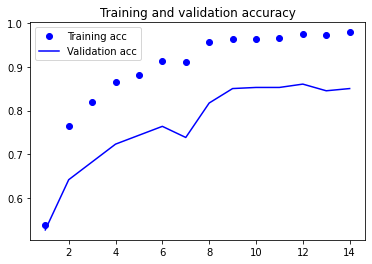

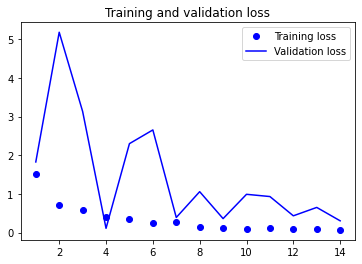

In [55]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

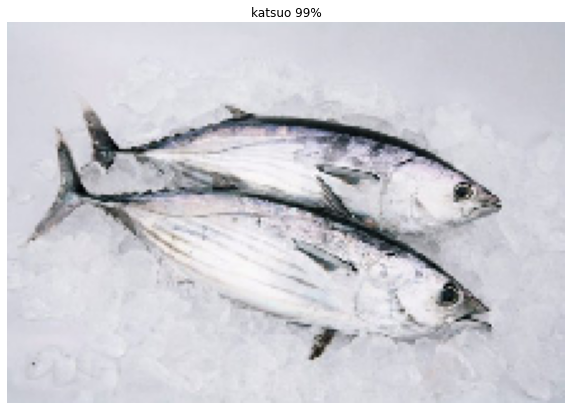

In [72]:
#画像多数の予測
%matplotlib inline
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
img1 = image.load_img('88.jpg', target_size=(image_height, image_width))
img = image.img_to_array(img1)
img = img/255.0
img = np.expand_dims(img, axis=0)
result = model.predict(img)
predicted = result.argmax(axis=1)
plt.figure(figsize=(10,10))
plt.axis("off")
percentage = int(result[0][predicted[0]] * 100)
plt.title(classes[predicted[0]] + " " + str(percentage) + "%")
plt.imshow(img1, cmap=plt.cm.binary)
plt.show()

In [73]:
pip install coremltools -U

Requirement already up-to-date: coremltools in /usr/local/lib/python3.6/dist-packages (3.4)


In [74]:
import coremltools
coremltools.converters.keras.convert('fish_modelv3.h5',
   input_names = 'image',
   output_names = ['classLabelProbs', 'classLabel'],
   image_input_names = 'image',
   class_labels=classes).save('fish_modelv3.mlmodel')

OperatorNotAllowedInGraphError: ignored